In [91]:
import pandas as pd
from datasets import Dataset

def prepare_ragas_dataset(df: pd.DataFrame, answer_column: str) -> Dataset:
    """
    Prepare RAGAS evaluation dataset

    Medical report structure:
    - clinical_information: Patient clinical information (symptoms, medical history, etc.)
    - findings: Imaging findings
    - impression: Radiological impression/diagnostic conclusion

    Evaluation setup:
    - question: Construct clear question (generate diagnostic question based on clinical information)
    - contexts: Provide findings as context
    - answer: Model-generated impression
    - ground_truth: Actual impression
    """
    questions = []
    contexts = []

    for _, row in df.iterrows():
        # Construct clear diagnostic question
        clinical_info = str(row['clinical_information']).strip()
        findings = str(row['findings']).strip()

        # Create balanced question format - emphasize relevance and similarity to ground truth
        question = f"Based on the following clinical information: {clinical_info}, provide a radiological impression that directly addresses the clinical concern using findings from the imaging study."

        # contexts should be a list of lists, where each element is a list of contexts
        context = [findings]  # Only use findings as context

        questions.append(question)
        contexts.append(context)

    data_dict = {
        'question': questions,
        'contexts': contexts,
        'answer': df[answer_column].fillna('').tolist(),
        'ground_truth': df['impression'].fillna('').tolist()
    }
    return Dataset.from_dict(data_dict)

# Read single CSV file
comparison_df = pd.read_csv('comparison_results.csv')

# Data cleaning: remove rows with empty key fields
print(f"Original dataset size: {len(comparison_df)}")

# First fill NaN with empty strings to avoid comparison errors
for col in ['clinical_information', 'findings', 'impression', 'base_model_answer', 'memento_model_answer']:
    if col in comparison_df.columns:
        comparison_df[col] = comparison_df[col].fillna('')

# Remove empty rows
comparison_df = comparison_df[
    (comparison_df['clinical_information'].astype(str).str.strip() != '') &
    (comparison_df['findings'].astype(str).str.strip() != '') &
    (comparison_df['impression'].astype(str).str.strip() != '') &
    (comparison_df['base_model_answer'].astype(str).str.strip() != '') &
    (comparison_df['memento_model_answer'].astype(str).str.strip() != '')
]

print(f"Cleaned dataset size: {len(comparison_df)}")

if len(comparison_df) == 0:
    raise ValueError("No valid data after cleaning! Please check your CSV file.")

# Prepare two datasets using different columns from the same DataFrame
baseline_dataset = prepare_ragas_dataset(comparison_df, 'base_model_answer')
memento_dataset = prepare_ragas_dataset(comparison_df, 'memento_model_answer')

print("\nDatasets prepared for evaluation.")
print("\n=== Sample Data ===")
print(f"Question: {baseline_dataset[0]['question']}")
print(f"\nContexts: {baseline_dataset[0]['contexts']}")
print(f"\nBase Answer (first 200 chars): {baseline_dataset[0]['answer'][:200]}...")
print(f"\nGround Truth (first 200 chars): {baseline_dataset[0]['ground_truth'][:200]}...")

# Validate data structure
print("\n=== Data Validation ===")
print(f"Number of samples: {len(baseline_dataset)}")
print(f"All questions non-empty: {all(len(q.strip()) > 0 for q in baseline_dataset['question'])}")
print(f"All contexts non-empty: {all(len(c[0].strip()) > 0 for c in baseline_dataset['contexts'])}")
print(f"All answers non-empty: {all(len(a.strip()) > 0 for a in baseline_dataset['answer'])}")
print(f"All ground_truths non-empty: {all(len(g.strip()) > 0 for g in baseline_dataset['ground_truth'])}")

Original dataset size: 10
Cleaned dataset size: 9

Datasets prepared for evaluation.

=== Sample Data ===
Question: Based on the following clinical information: Preoperative planning for brain tumor. History of a left temporal AVM treated with radiation., provide a radiological impression that directly addresses the clinical concern using findings from the imaging study.

Contexts: ['There is a heterogeneous left supratentorial and infratentorial lesion with associated cystic compartments, some of which contain fluid-fluid levels suggestive of hemorrhage. There is also surrounding vasogenic edema in the left cerebellar hemisphere. There is marked effacement of the fourth ventricle and dilatation of the third and fourth ventricles, which have increased in size slightly. There is also marked mass effect upon the brainstem. There is also a similar contiguous heterogeneous lesion within the left temporal and occipital lobes with surrounding vasogenic edema. There is no herniation. There ar

In [ ]:
import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Set API key from environment variable
# Please set your OpenAI API key in environment: export OPENAI_API_KEY='your-key-here'
if "OPENAI_API_KEY" not in os.environ:
    raise ValueError("Please set OPENAI_API_KEY environment variable")

# Configure RAGAS LLM and Embeddings - Using GPT-3.5-turbo for evaluation
evaluator_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
evaluator_embeddings = OpenAIEmbeddings()

print("✓ API Key configured")
print(f"✓ Evaluator LLM: {evaluator_llm.model_name}")
print(f"✓ Evaluator Embeddings: OpenAIEmbeddings")

In [93]:
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    answer_similarity,
    answer_relevancy
)

# Evaluate models using RAGAS metrics
def evaluate_model(dataset: Dataset, model_name: str):
    print(f"\nEvaluating {model_name}...")

    metrics = [
        answer_correctness,
        answer_similarity,
        answer_relevancy
    ]

    results = evaluate(
        dataset=dataset,
        metrics=metrics,
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )

    return results


print("Running RAGAS evaluations with configured LLM...")
baseline_results = evaluate_model(baseline_dataset, "Base Model")
lora_results = evaluate_model(memento_dataset, "Memento Model")

Running RAGAS evaluations with configured LLM...

Evaluating Base Model...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating:  56%|█████▌    | 15/27 [00:10<00:06,  1.92it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]



Evaluating Memento Model...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating:   4%|▎         | 1/27 [00:07<03:16,  7.54s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 27/27 [00:31<00:00,  1.17s/it]



--------------------------------------------------
BASELINE MODEL RESULTS
--------------------------------------------------
{'answer_correctness': 0.4257, 'answer_similarity': 0.9014, 'answer_relevancy': 0.8168}

--------------------------------------------------
Memento MODEL RESULTS
--------------------------------------------------
{'answer_correctness': 0.5709, 'answer_similarity': 0.9251, 'answer_relevancy': 0.7976}

--------------------------------------------------
Metrics comparison (mean scores)
--------------------------------------------------
            Metric  Baseline  Memento
Answer Correctness  0.425707 0.570881
 Answer Similarity  0.901435 0.925140
  Answer Relevancy  0.816837 0.797609

--------------------------------------------------
Detailed comparison with improvement
--------------------------------------------------
            Metric  Baseline  Memento  Improvement (%)
Answer Correctness  0.425707 0.570881            34.10
 Answer Similarity  0.901435 0.9251

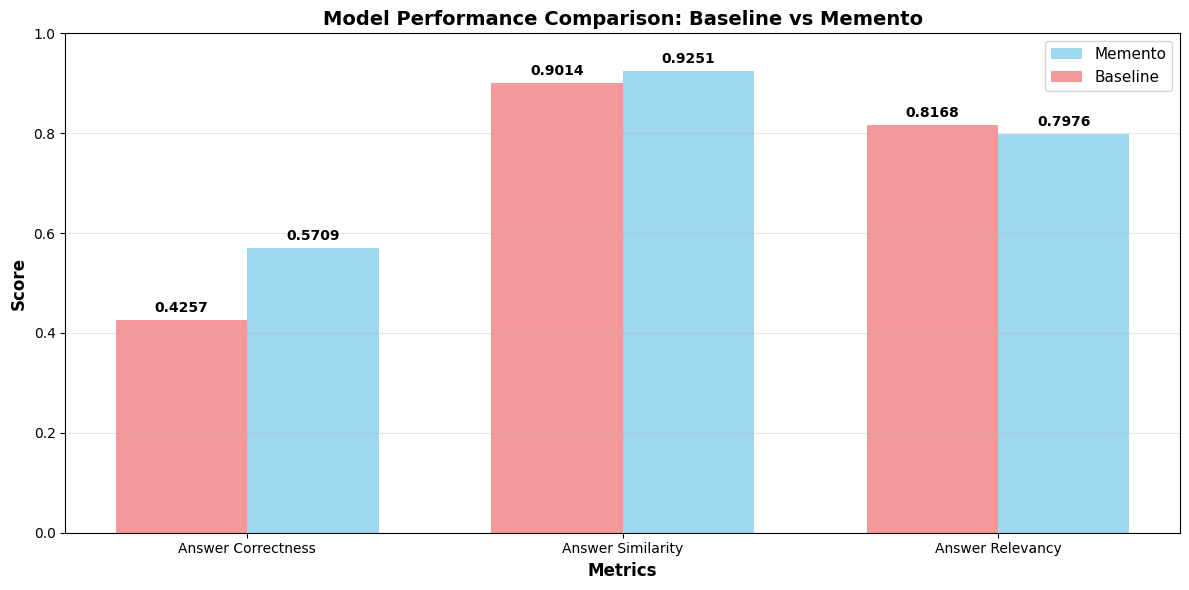

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


print("\n" + "-"*50)
print("BASELINE MODEL RESULTS")
print("-"*50)
print(baseline_results)

print("\n" + "-"*50)
print("Memento MODEL RESULTS")
print("-"*50)
print(lora_results)

# Calculate mean score
def get_mean_score(results, metric_name):
    value = results[metric_name]
    if isinstance(value, list):
        return np.mean(value)
    return value

# Compare metrics by calculating means
metrics_comparison = pd.DataFrame({
    'Metric': ['Answer Correctness', 'Answer Similarity', 'Answer Relevancy'],
    'Baseline': [
        get_mean_score(baseline_results, 'answer_correctness'),
        get_mean_score(baseline_results, 'answer_similarity'),
        get_mean_score(baseline_results, 'answer_relevancy')

    ],
    'Memento': [
        get_mean_score(lora_results, 'answer_correctness'),
        get_mean_score(lora_results, 'answer_similarity'),
        get_mean_score(lora_results, 'answer_relevancy')
    ]
})

print("\n" + "-"*50)
print("Metrics comparison (mean scores)")
print("-"*50)
print(metrics_comparison.to_string(index=False))

# Calculate improvement
metrics_comparison['Improvement (%)'] = ((metrics_comparison['Memento'] - metrics_comparison['Baseline']) / metrics_comparison['Baseline'] * 100).round(2)

print("\n" + "-"*50)
print("Detailed comparison with improvement")
print("-"*50)
print(metrics_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(metrics_comparison))
width = 0.35

lora_bars = ax.bar([i + width/2 for i in x], metrics_comparison['Memento'],
                    width, label='Memento', alpha=0.8, color='skyblue')
baseline_bars = ax.bar([i - width/2 for i in x], metrics_comparison['Baseline'],
                        width, label='Baseline', alpha=0.8, color='lightcoral')


ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison: Baseline vs Memento', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison['Metric'], rotation=0, ha='center')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bars in [baseline_bars, lora_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
